<a href="https://colab.research.google.com/github/SudeepSarkar/sarkar-computer-vision-lectures/blob/main/CV_Module_4_2_Point_features_and_descriptors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2021, Sudeep Sarkar, University of South Florida, Tampa

# You will learn about

In this module, you will learn how to detect salient points in an image that are robust to viewpoint and illumination changes. In particular, you will learn about SIFT features and descriptors and the HOG descriptor. In the following lectures, we will explore how we can use these points for many geometry-related problems in computer vision, such as image matching, motion estimation, and depth estimation.

* You will learn about the four steps of the SIFT feature detector.

* You will study the four steps of the SIFT feature detection scheme: scale-space extrema detection, key-point localization, orientation estimation, and the SIFT keypoint descriptor.

* As an alternative to the SIFT descriptor, you will learn about the histogram of gradients (HOG) descriptor. This descriptor helped detect persons in images in the pre-deep learning era.


## Code: Initialize notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/'
!ls "$data_dir"

Mounted at /content/drive
 0005_Walking001.xlsx			     left01.jpg
 0008_ChaCha001.xlsx			     left02.jpg
 2011_09_26_drive_0048_sync		     left03.jpg
 2011_09_26_drive_0048_sync.zip		     left04.jpg
 20211003_082148.jpg			     left05.jpg
 20211003_082201.jpg			     left06.jpg
 apple.jpg				     left07.jpg
'Armes 1.png'				     left08.jpg
'Armes 2.png'				     left09.jpg
 blog_danforth_monica_mural_panorama.jpg     left11.jpg
 blog_monica_mural_brown_white.jpg	     left12.jpg
 blog_monica_mural_fish_tree_windows1.jpg    lizard.jpg
'cats and dogs.jpg'			     MOT16-08-raw.webm
 convenience-store-cereal01.jpg		     mountain_peak_1.png
 declaration_of_independence_stone_630.jpg   mountain_peak_2.png
 Fig3_3a.jpg				     parking_lot_meva_1.png
 Fig3_4a.jpg				     parking_lot_meva_2.png
 Fig3_4c.jpg				     parking_lot_meva_3.png
 hawaii.png				    'Road Signs Kaggle'
 house_1.png				     semper
 house_2.png				    'Superbowl 2021_1.png'
 house_facade.png			    'Superbowl 2021_2.png'
 IMG_01

In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import scipy.ndimage as scimage
import torch.nn as nn
from skimage import io
from skimage.feature import peak_local_max
#!pip install opencv-contrib-python==4.4.0.44
import cv2
print (cv2 .__version__)

np.set_printoptions(precision=2, suppress=True)

4.6.0


## Dataset used in this module

We will use images from the road sign dataset that is available at

https://www.kaggle.com/andrewmvd/road-sign-detection

There are many other datasets that are larger, more varied, and well annotated that you also consider, scuch as the Mapillary Traffic Sign Dataset https://www.mapillary.com/dataset/trafficsign




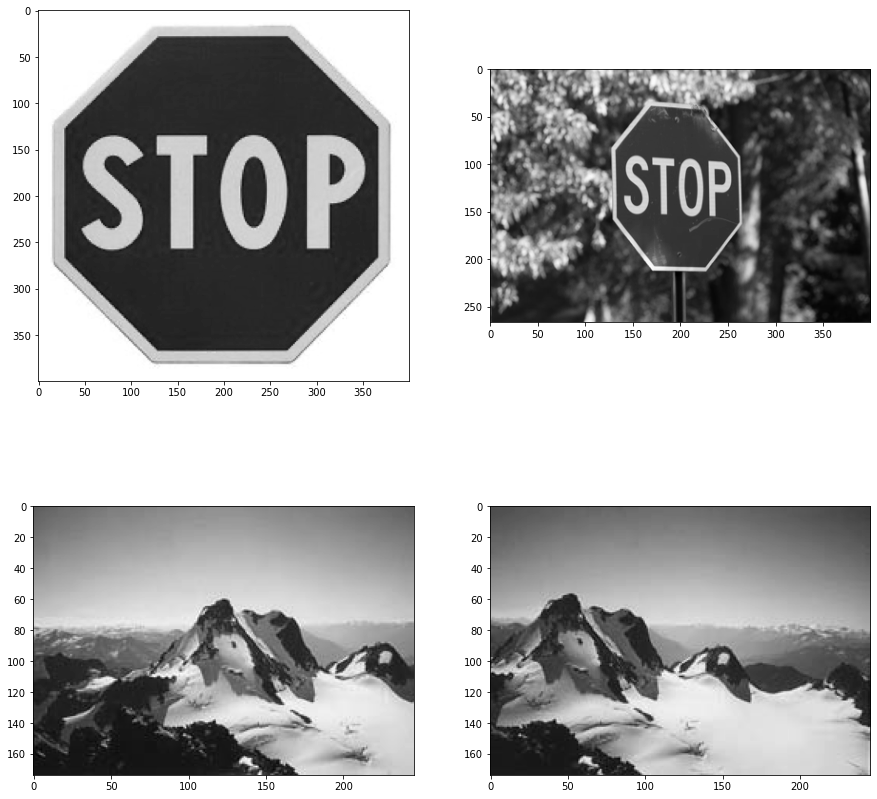

In [3]:
# Read in some example image pairs

traffic_sign1 = cv2.imread(data_dir + 'Road Signs Kaggle/images/road80.png')
traffic_sign1 = cv2.cvtColor(traffic_sign1, cv2.COLOR_BGR2GRAY) # note BRG as opposed to RGB
traffic_sign2 = cv2.imread(data_dir + 'Road Signs Kaggle/images/road92.png')
traffic_sign2 = cv2.cvtColor(traffic_sign2, cv2.COLOR_BGR2GRAY) # note BRG as opposed to RGB

image_1 = cv2.imread(data_dir + '/mountain_peak_1.png')
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY) # note BRG as opposed to RGB
image_2 = cv2.imread(data_dir +'mountain_peak_2.png')
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY) # note BRG as opposed to RGB

fig, ax = plt.subplots(nrows=2, ncols=2) 
fig.set_size_inches (15, 15)
ax[0,0].imshow(traffic_sign1, 'gray')
ax[0,1].imshow(traffic_sign2, 'gray');
ax[1,0].imshow(image_1, 'gray')
ax[1,1].imshow(image_2, 'gray');


# Motivation

* Application context: Match images of the same object, e.g., planar (2D) road signs (physically different instances) taken from different viewpoints or pictures of the same scene from other locations to create a panorama.

* Another application context: To place a 3D model of an object in the context of the natural world, as in augmented reality applications, we need to locate points to estimate the geometry of the 3D world. See Amazon AR view, for example, https://www.amazon.com/adlp/arview

* The **core computer vision problem** in these applications is given two images to estimate the geometric transformations between images. The first step for solving this problem is establishing correspondences between **feature points** found in the two images. 

* A **feature point** is an image location, along with a local descriptor of the image pixel values around it, for example, the histogram of the image gradients in a small neighborhood around the pixel.

* What are good **feature points**? They are **distinctive** image pixels in an image, such as a bright dot or a corner, anything that makes the neighborhood of the image pixel unique.

* Scale and rotation are issues when matching images across views or locations. Need the point features to be invariant to scale and rotation.

* David Lowe aimed to formulate a new detector, called SIFT, for significant points and a robust descriptor for the variations corresponding to typical viewing conditions. The descriptor is the most-used part of SIFT.


# The SIFT (Scale-Invariant Feature Transform) Detector and Descriptor

* D. G. Lowe, "[Object recognition from local scale-invariant features](https://ieeexplore.ieee.org/document/790410)," Proceedings of the Seventh IEEE International Conference on Computer Vision, Kerkyra, Greece, 1999, pp. 1150-1157 vol.2, DOI: 10.1109/ICCV.1999.790410.

* David G. Lowe, "[Distinctive image features from scale-invariant keypoints](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf)," International Journal of Computer Vision, 60, 2 (2004), pp. 91-110. 

* David Lowe's webpage: [The SIFT Keypoint Detector](https://www.cs.ubc.ca/~lowe/keypoints/)

* One of the most influential feature detectors, vestiges of which remain in various forms in many aspects of computer vision.

* The SIFT feature brought together different aspects of signal-level computer vision. It synthesized the concepts of Gaussian filtering, image scales, image pyramids, and local geometric invariance to design a feature detector and descriptor that is robust, stable, and works for many different conditions without the need for training data!

* This material is also in your textbook in Section 7.1 (page 430, second edition), but at a high level and in condensed form.


# Four steps of SIFT feature
1. Scale-space extrema detection by searching over multiple scales and locations
2. Keypoint localization by fitting a model to estimate the local scale and select keypoint based on stability.
3. Orientation assignment to each local region to capture salient local orientation, which is helpful in rotation invariant matching
4. Keypoint description using local image gradients, choosing the correct scale, and factoring out the local rotation, resulting in a robust descriptor.

## 1 - Scale-space extrema detection

* The continuous version of the concept of an image pyramid is the **scale space**.

* Search for stable features across multiple scales using a continuous scale function. So, we have to create a scale space.

* The scale space of an image is a **continuous** function $L(x,y,\sigma)$ produced from the convolution of a Gaussian kernel (at different scales) with the input image.

\begin{eqnarray}
L(x,y,\sigma) & = & f(x, y) \star g(x, y, \sigma) \\
&  = & \int_x \int_y f(u, v) g(u - x, v - y, \sigma) du dv
\end{eqnarray}

where 
\begin{equation}
g(x, y, \sigma) = \frac{1}{2 \pi \sigma^2} \exp -\frac{x^2 + y^2}{2 \sigma^2}
\end{equation}

>> See ([Lindeberg, 1998](https://people.kth.se/~tony/papers/cvap222.pdf)) for a detailed mathematical exposition of the vital concept of scale.

* Under various assumptions, a Gaussian function is the best function for creating an image scale space. 

* The SIFT detector finds local maxima in this Gaussian scale space or pyramid, i.e., maxima in all three directions - $x, y, \sigma$.

* To detect maxima along the scale direction, we have to compute derivatives with respect to the scale, $\sigma$ and detect maxima.

* For this, we exploit an important property

\begin{eqnarray}
\frac{\partial}{\partial \sigma} g(x, y, \sigma) & = & \sigma \nabla^2 g(x, y, \sigma) \\
& \approx & \frac{g(x, y, k\sigma) - g(x, y, \sigma)}{(k-1)\sigma} \\
g(x, y, k\sigma) - g(x, y, \sigma) & \approx & (k-1)\sigma^2 \nabla^2 g(x, y, \sigma)
\end{eqnarray}

* Ideally, $k$ should be small. For the current purposes, $k=2^{\frac{1}{s}}$ performed well, where $s=3$ resulted in the most stable key points.

* Incidentally, here is the mathematical reason why the difference of Gaussian (DoG) was similar to the Laplacian of Gaussian (LoG) output we had observed earlier.

* In practice, we use a discretized version of the scale space called the image pyramid, specifically the Laplacian pyramid, which emphasizes corners and edges.

*  We can construct this pyramid from Gaussian scale space through the Difference of Gaussians.

* We subtract adjacent Gaussian images to create the Difference-of-Gaussian images on the right. The initial image is **convolved** repeatedly with Gaussians for each octave of scale-space to produce the set of scale-space images shown on the left. After each octave, the Gaussian image is down-sampled by a factor of 2, and we repeat the process.
> Note: Sequential convolution by Gaussian functions, with scales $\sigma_1$ and $\sigma_2$, is equivalent to convolution by a single Gaussian with scale = $\sigma_1 + \sigma_2$: 

\begin{equation} 
(f(x, y) \star g (x, y, \sigma_1)) \star g (x, y, \sigma_2)) = f(x, y) \star g (x, y, \sigma_1+\sigma_2)$
\end{equation}

* Lowe used three scales per octave. The number of octaves was 4. However, this is dependent on the image size. Larger images need more octaves than smaller ones. For very low-resolution images, you probably would not need that many octaves. Lowe used a starting sigma value of 1.6, but that depends on your image quality.


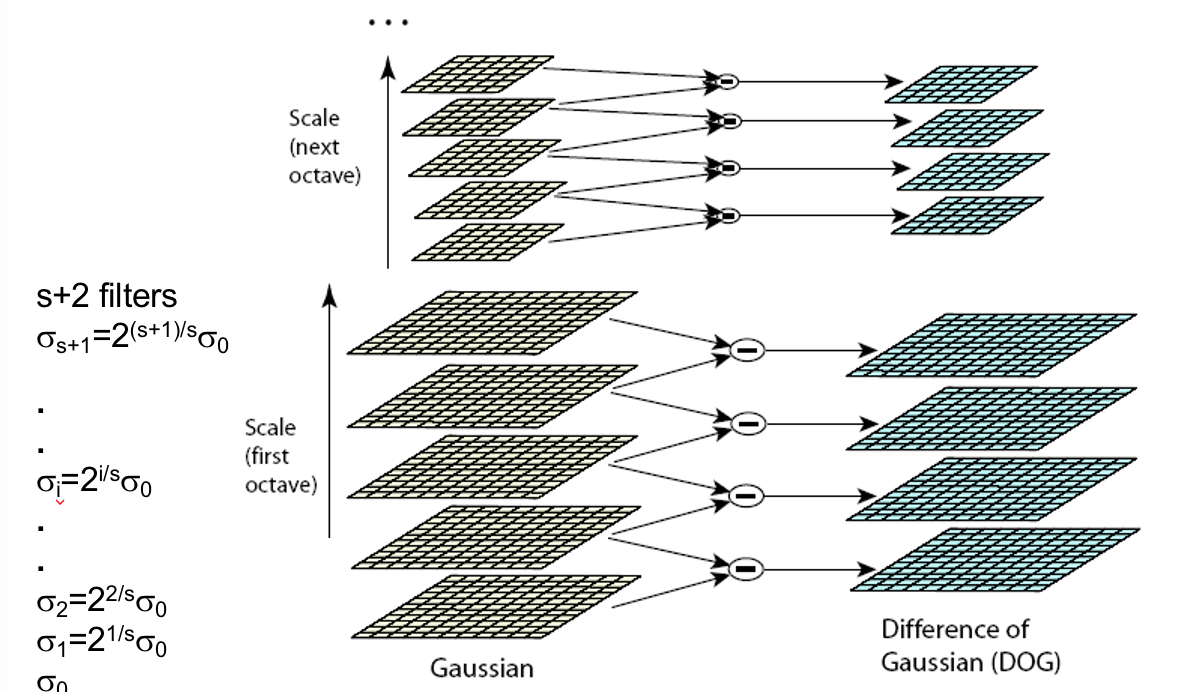

The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

### Code: SIFT Pyramid

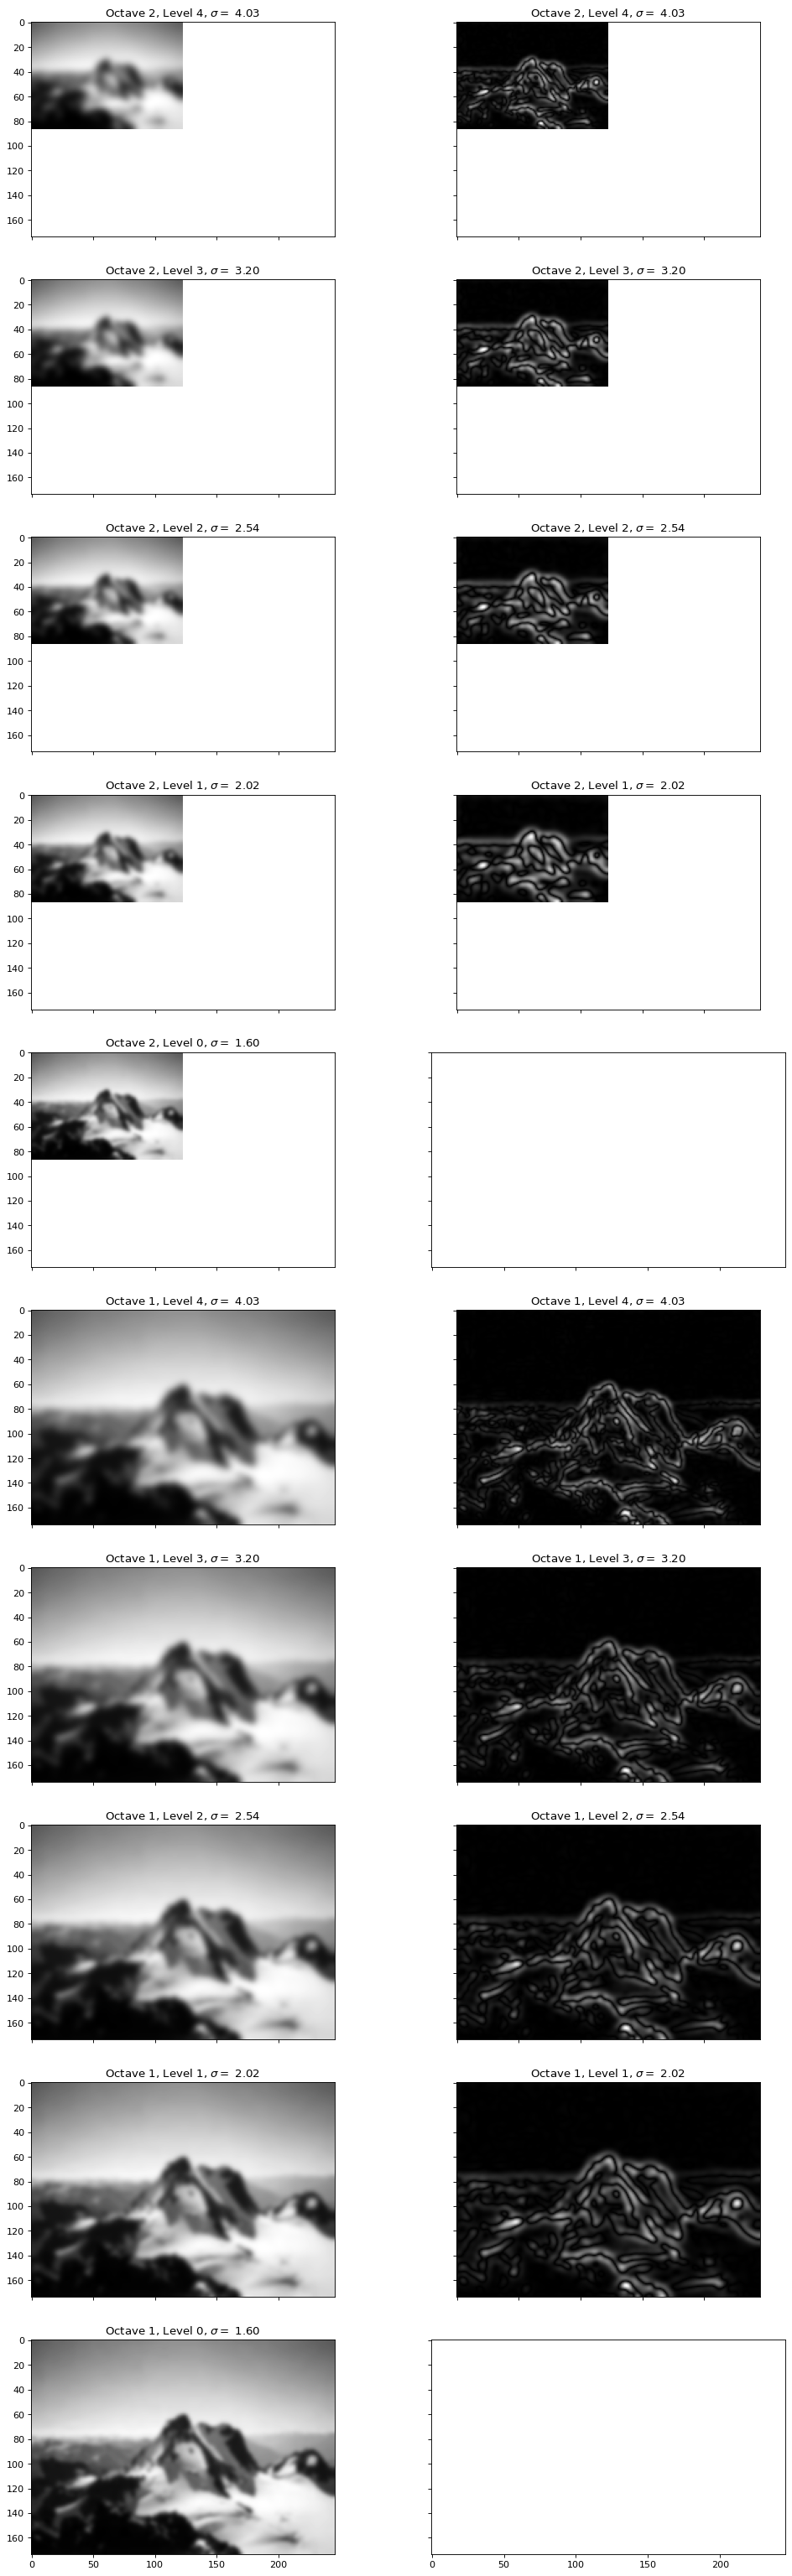

In [4]:
#------------------1D Gaussian kernel---------------------------
def gaussian (x, sigma):
    g = np.exp(-(x**2/(2*sigma*sigma)))*(1/(np.sqrt(2*np.pi)*sigma))
    return (g/g.sum())

#------------------Gaussian convolution code---------------------------
def image_convolve_gaussian (image, sigma) :
    N = np.round(3*(sigma+1))
    t = np.arange(-N, N)  # Note the width of the kernel, need to be this large to capture most of the shape
    g = gaussian(t, sigma) # 1D gaussian kernel
    # Process rows
    output = image.copy()
    for i in range (image.shape[0]):
        output[i,:] = scimage.convolve(output[i, :], g)
    # Process columns
    for j in range (image.shape[1]):
        output[:, j] = scimage.convolve(output[:, j], g)
    return (output)
#----------------Image to be processed changed to float type-----------------------------------
# Using an image read in earlier 
 
image = image_1.astype(float)  # need to change type from uint8 to float
#------------------------------------------------------------------
# Octave stack -- created by *repeated* convolution with a Gaussian function with 
# sigma = np.power(2, 1/3), s=3 (see Lowe's paper for what the parameter s is about)
# Each octave consists of a number of Gaussian convolved images, until the scale of
# smoothing, sigma, is doubled.

# We store the  two pyramids (gauss and log) as a list (octave) of lists (levels)
gauss_octave = []
gauss_level = []  # stored in order: level_0, level_1, level_2, level_s+1  (s+2)
log_octave = []
log_level = []    # stored in order: level_0, level_1, level_2, level_s+1  (s+2)

num_octaves = 2
s = 3
sigma = []
sigma.append(1.6)

gauss_level.append(image_convolve_gaussian (image, sigma[-1]))
for octave in range(num_octaves):
    # create the s+2 levels for each octave
    for i in range(1, s+2) : #s = 1, .... s+1
        smoothed = image_convolve_gaussian (gauss_level[-1], np.power(2, 1/s))
        gauss_level.append(smoothed)
        log_level.append(gauss_level[-1]-gauss_level[-2])
        sigma.append(sigma[-1] * np.power(2, 1/s))

    # insert into octave lists
    gauss_octave.append(gauss_level)
    log_octave.append(log_level)

    # ready the level lists for the next octave
    next_octave_start = gauss_level[-2] # the second last level of the previous octave is the starting image of the next octave
    height, width = next_octave_start.shape
    gauss_level = [] 
    log_level = []
    gauss_level.append(next_octave_start[1:height:2, 1:width:2])  # reduce size by half for the next octave
    sigma.append(1.6)  # resetting the sigma for the next octave

#------------------display-----------------------------------------
total_levels = (s+2)*num_octaves

fig, ax = plt.subplots( nrows=total_levels, ncols=2, dpi=80, sharex=True, sharey=True)
fig.set_size_inches (15, 50)
k = 0
for octave in range (num_octaves-1,-1,-1) :
    for levels in range (s+2) :
        ax[k,0].imshow(gauss_octave[octave][s+1-levels], 'gray')
        ax[k,0].set_title('Octave {}, Level {}, $\sigma=$ {:0.2f}'.format(octave+1, s+1-levels, sigma[-k-2]))
        if (levels < s+1):
            ax[k,1].imshow(np.abs(log_octave[octave][levels]), 'gray')
            ax[k,1].set_title('Octave {}, Level {}, $\sigma=$ {:0.2f}'.format(octave+1, s+1-levels, sigma[-k-2]))
        k = k+1


#Assignment: Structure of SIFT Pyramid

Work out how many images are part of a SIFT pyramid over 3 octaves and s = 4. Show your rationale.

## 2 -Key Point Localization

* Detect maxima and minima of difference-of-Gaussian in scale space

* Each point is compared to its 8 neighbors in the current image and 9 neighbors each in the scales above and below.


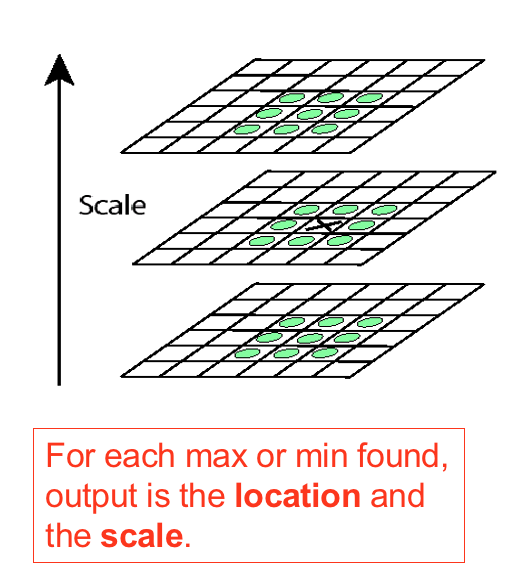


The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

* Once we have found a key point candidate by comparing a pixel to its neighbors (in the 3D scale volume), the next step is to precisely fit the nearby data for location, scale, and the **ratio of principal curvatures** of the image function. 

* If we think of the image as a smooth surface over the pixel locations, then at any point on the surface, we can define mathematical quantities that capture the local curvature: **the principal curvatures**. See -- https://en.wikipedia.org/wiki/Principal_curvature

* We can use this information to reject low-contrast points (sensitive to noise) or poorly localized points along an edge.

* The [Hessian matrix ](https://en.wikipedia.org/wiki/Hessian_matrix) helps eliminate edge responses based on the curvature of the DoG (or LoG) filtered image function, $D(x, y)$. A poorly defined peak in the difference-of-Gaussian function will have a sizeable principal curvature across the edge but a small one in the perpendicular direction. 

* We can estimate the principal curvatures at each pixel of the image using the Hessian function. The principal curvatures of $D(x, y)$ are proportional to the eigenvalues of ${\bf H} (x, y)$.

\begin{equation}
{\bf H} (x, y) = \left [ \begin{matrix} \frac{\partial^2}{\partial x^2} D(x, y) & \frac{\partial^2}{\partial x \partial y} D(x, y) \\ \frac{\partial^2}{\partial y \partial x} D(x, y) & \frac{\partial^2}{\partial y^2} D(x, y) \end{matrix} \right ]
\end{equation}


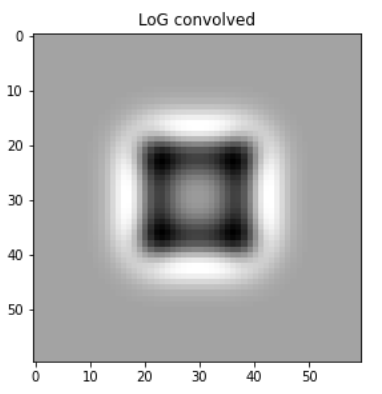

## 3 -Orientation Estimation
* The keypoint scale is used to select the Gaussian smoothed image, $L$, with the closest scale to perform all computations in a scale-invariant manner. 

* For each image sample, $L(x, y)$, at this scale, we precompute the gradient magnitude, $m(x, y)$, and orientation, $(x, y)$, using pixel differences to approximate the derivative operation.

* An orientation histogram is formed from the gradient orientations of sample points within a region around the key point. The orientation histogram has 36 bins covering the 360-degree range of directions. We weight each sample added to the histogram by its gradient magnitude and a Gaussian-weighted circular window with  1.5 times the keypoint scale.

* Peaks in the orientation histogram correspond to the dominant directions of local gradients. The highest peak in the histogram is detected, and we use any other local peak within 80% of the highest peak to create a key point with that orientation.

* Each key specifies stable 2D coordinates (x, y, scale, orientation)


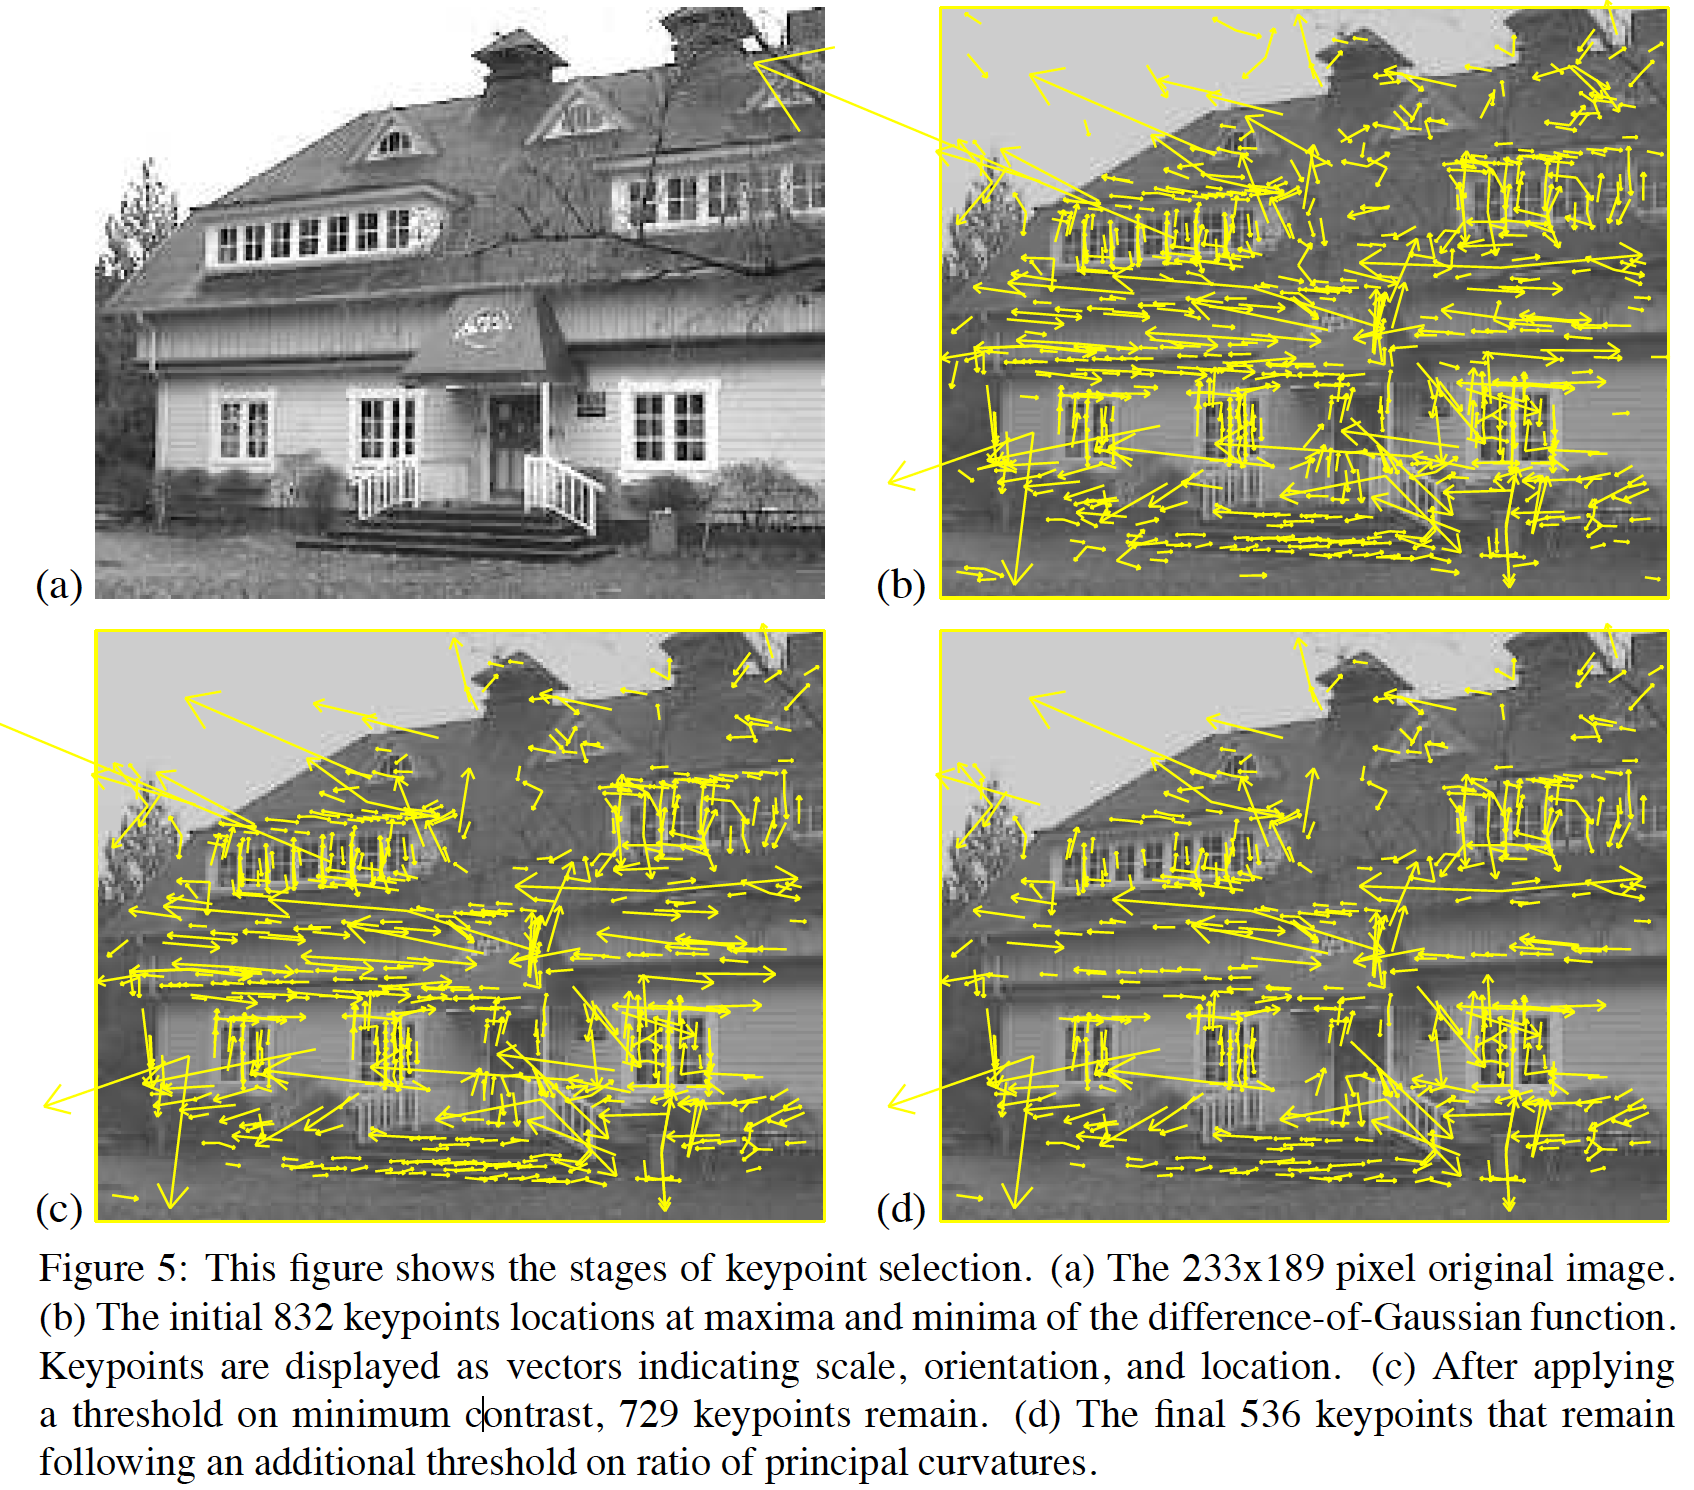

The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

#### Normalize localization with orientation

1. Rotate the window to standard orientation

2. Scale the window size based on the scale at which we found the point.

## 4 -SIFT Keypoint Descriptor
1. Use the normalized region about the keypoint
2. Compute gradient magnitude and orientation at each point in the region
3. Weight them by a Gaussian window overlaid on the circle
4. Create an orientation histogram over the 4 X 4 subregions of the window
5. We used 4 X 4 descriptors over 16 X 16 sample array in practice. 4 X 4 times eight directions give a vector of 128 values.

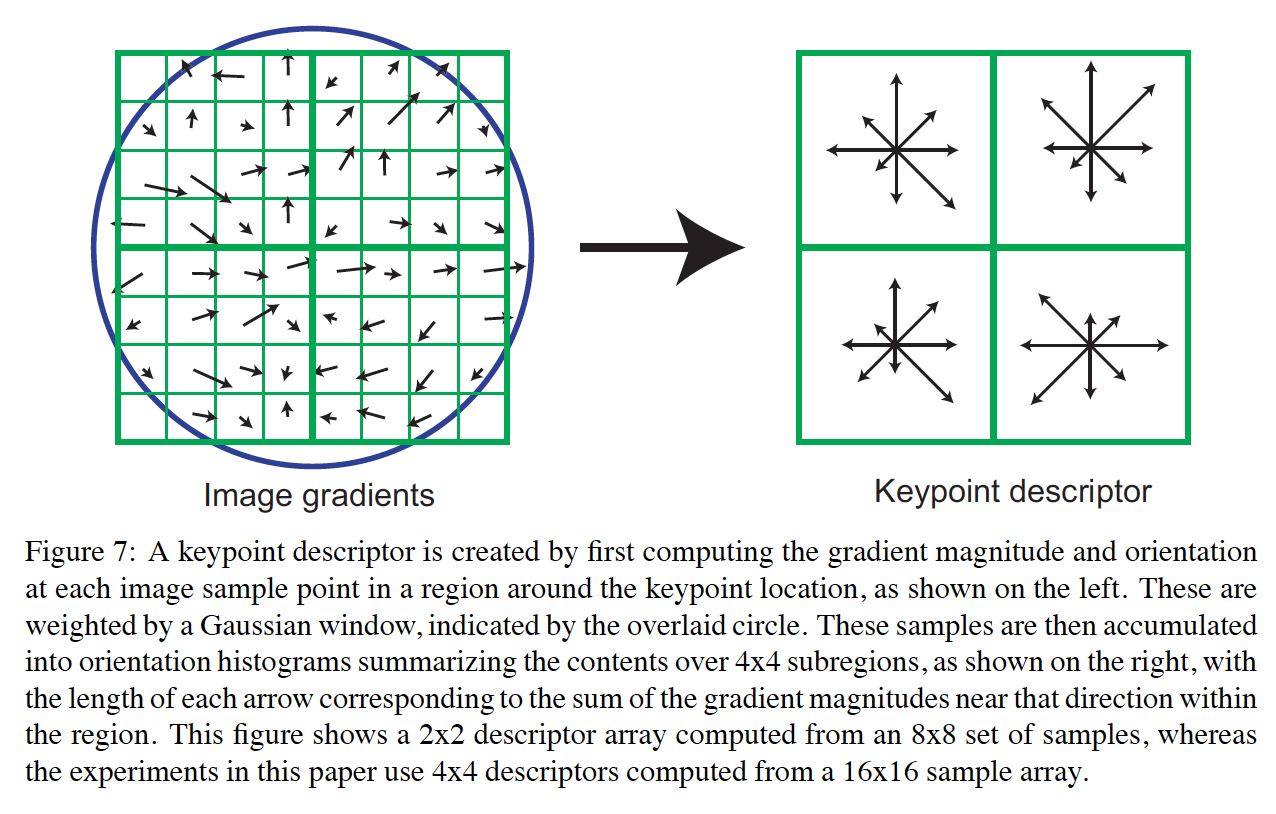

The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

### Code: OpenCV SIFT detector and descriptor

The OpenCV tutorial below is worth reading; however, note that the code snippets used in the tutorial are for cv and not cv2. 

https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html


There is also a standalone python implementation that seems to be good. **However, I have not tried or vetted it to evaluate the implementation's fidelity to the original Lowe paper.** If you want, you can experiment with it.
https://github.com/rmislam/PythonSIFT



Input image size: (400, 400)

 Keypoint #5 (of 223) in (image 1):
 angle=190.37, (octave, layer, scale)=2.00 3.00 0.25, size=27.20, pt=(43.61314010620117, 134.20339965820312)

Note: 2^octave * scale = 1. So, octave = -1 => scale = 2

 Keypoint 5 descriptor (image 1): Shape(223, 128), Values[5]=
[ 25.  90.   7.  13.  21.  39.   5.   5.  98.  32.   3.  15.  18. 101.
  23.   7. 145.  64.   0.   0.   2.   4.   2.   3.   7.   2.   0.   0.
   0.   0.   0.   0.  50.  67.  26.   8.   9.  17.   6.  67.  72.  29.
  29.  84.  54.  39.   5.  22. 145.  69.   2.  12.  10.   3.   1.  21.
  27.   4.   0.   0.   0.   0.   0.   2.  11.  33.  94.  36.   6.   4.
   1.  13.  78.  11.  78.  64.   3.   0.   0. 145. 145.   6.   2.   5.
   1.   0.   0. 145.  19.   0.   0.   0.   0.   0.   0.  15.  19.   1.
   5.   3.   0.   0.   0.  82.  87.   1.   1.   0.   0.   0.   0. 145.
  35.   0.   0.   0.   0.   0.   0. 130.   1.   0.   0.   0.   0.   0.
   0.   3.]

 Matches: # = 44, 7th entry: distance = 1147.0 betwe

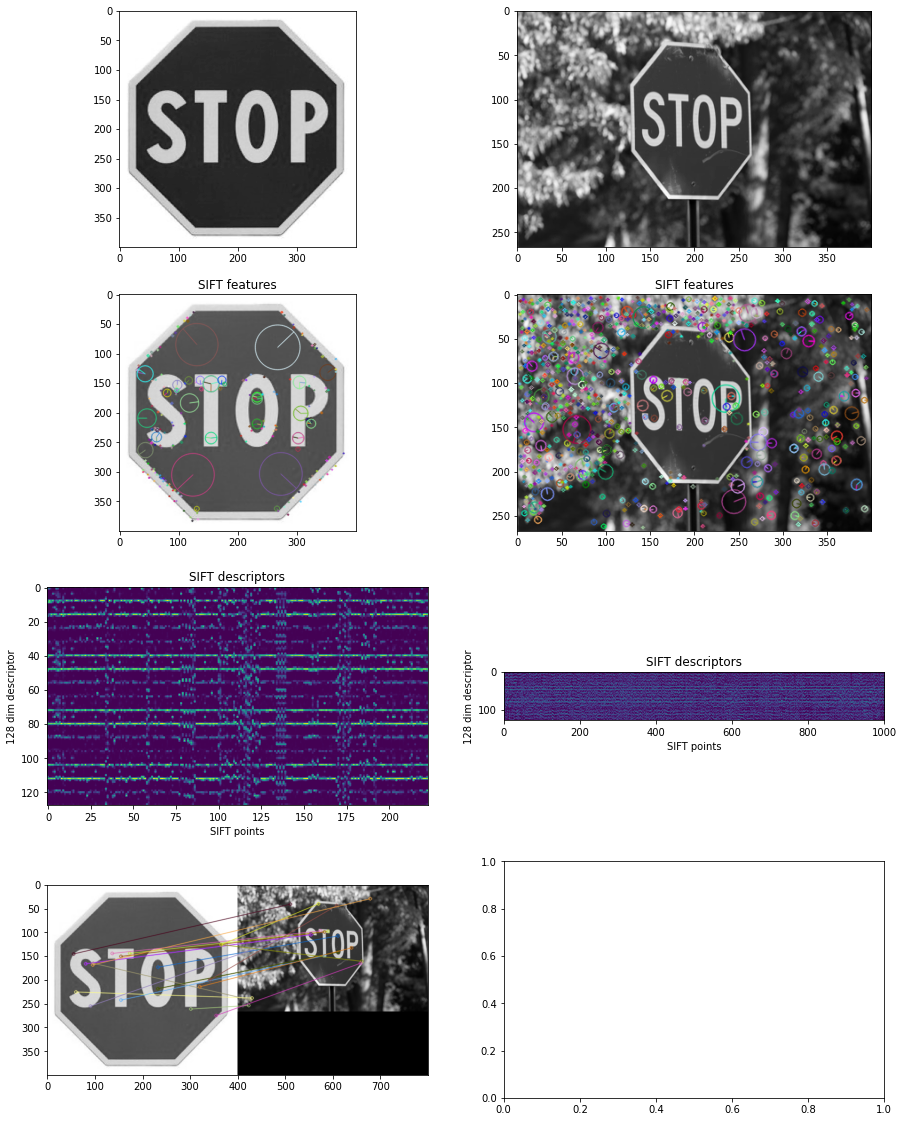

In [5]:

#image_1 = cv2.imread(data_dir + 'mountain_peak_1.png')
#image_2 = cv2.imread(data_dir + 'mountain_peak_2.png')
#image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
#image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)


image_1 = traffic_sign1
image_2 = traffic_sign2
print("Input image size:", image_1.shape)

sift = cv2.SIFT_create()
# For more details see https://docs.opencv.org/master/d7/d60/classcv_1_1SIFT.html
# Default values
# static Ptr<SIFT> cv::SIFT::create	(	int 	nfeatures = 0,
# int 	nOctaveLayers = 3,
# double 	contrastThreshold = 0.04,
# double 	edgeThreshold = 10,
# double 	sigma = 1.6 
# )	
#
# nfeatures: The number of best features to retain. The features are ranked by their scores 
#           (measured in SIFT algorithm as the local contrast)
# nOctaveLayers: The number of layers in each octave. 3 is the value used in D. Lowe paper. 
#           The number of octaves is dependent on the image resolution. 
# contrastThreshold: The contrast threshold used to filter out weak features in semi-uniform 
#           (low-contrast) regions. The larger the threshold, the less features are produced by 
#           the detector. 
# edgeThreshold: The threshold used to filter out edge-like features. Note that the its meaning 
#           is different from the contrastThreshold, i.e. the larger the edgeThreshold, the less 
#           features are filtered out (more features are retained).
# sigma: The sigma of the Gaussian applied to the input image at the octave #0. If your image is 
#           captured with a weak camera with soft lenses, you might want to reduce the number.	

keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image_2, None)

# Keypoint class is described in at https://docs.opencv.org/master/d2/d29/classcv_1_1KeyPoint.html
# It is a data structure for salient point detectors in OpenCV. The class instance stores a keypoint, 
# i.e. a point feature.
# The keypoint is characterized by the 2D position, scale (proportional to the diameter of the 
# neighborhood that needs to be taken into account), orientation and some other parameters. 
# The keypoint neighborhood is then analyzed by another algorithm that builds a descriptor 
# (usually represented as a feature vector). The keypoints representing the same object in 
# different images can then be matched using KDTree or another method.
def unpackSIFTOctave(keypoint):
    """unpackSIFTOctave(kpt)->(octave,layer,scale)
    @created by Silencer at 2018.01.23 11:12:30 CST
    @brief Unpack Sift Keypoint by Silencer
    @param kpt: cv2.KeyPoint (of SIFT)
    """
    _octave = keypoint.octave
    octave = _octave&0xFF
    layer  = (_octave>>8)&0xFF
    if octave>=128:
        octave |= -128
    if octave>=0:
        scale = float(1/(1<<octave))
    else:
        scale = float(1<<-octave)
    return (octave, layer, scale)

#for i in range(len(keypoints_1)) :
i = 5
octave, layer, scale = unpackSIFTOctave(keypoints_1[i])
print('\n Keypoint #{} (of {}) in (image 1):\n angle={:0.2f}, (octave, layer, scale)={:0.2f} {:0.2f} {:0.2f}, size={:0.2f}, pt={}\n'.format(i, len(keypoints_1), keypoints_1[i].angle, 
                                                                    octave, layer, scale,
                                                                    keypoints_1[i].size, 
                                                                    keypoints_1[i].pt))
print('Note: 2^octave * scale = 1. So, octave = -1 => scale = 2')
print('\n Keypoint {} descriptor (image 1): Shape{}, Values[5]=\n{}'.format(i, descriptors_1.shape, descriptors_1[i,:]))

# FEATURE MATCHING
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# This is Brute Force OpenCV matcher: https://docs.opencv.org/master/d3/da1/classcv_1_1BFMatcher.html
# For each descriptor in the first set, this matcher finds the closest descriptor in the second set 
# by trying each one. This descriptor matcher supports masking permissible matches of descriptor sets.
# crossCheck -- If it is false, this is will be default BFMatcher behaviour when it finds the 
#               k nearest neighbors for each query descriptor. If crossCheck==TRUE, then the 
#               knnMatch() method with k=1 will only return pairs (i,j) such that for i-th query 
#               descriptor the j-th descriptor in the matcher's collection is the nearest and vice versa, 
#               i.e. the BFMatcher will only RETURN CONSISTENT pairs. Such technique usually produces best 
#               results with minimal number of outliers when there are enough matches. This is alternative 
#               to the ratio test, used by D. Lowe in SIFT paper.

matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

# The match class is described here: https://docs.opencv.org/master/d4/de0/classcv_1_1DMatch.html
print('\n Matches: # = {}, 7th entry: distance = {} between features {} (of {}) and {} \n'.format(len(matches), 
                                                                                      matches[7].distance,
                                                                                      matches[7].trainIdx,
                                                                                      matches[7].imgIdx,
                                                                                      matches[7].queryIdx))

#----------------------------------Display-------------------------------------------------------
# draw the detected key points for display purposes
sift_image1 = cv2.drawKeypoints(image_1, keypoints_1, image_1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
sift_image2 = cv2.drawKeypoints(image_2, keypoints_2, image_2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# draw matches
match_image = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, matches[:20], image_2, flags=2)


fig, ax = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches (15, 20)

ax[0,0].imshow(image_1, 'gray')
ax[0,1].imshow(image_2, 'gray')
ax[1,0].imshow(sift_image1)
ax[1,0].set_title('SIFT features')
ax[1,1].imshow(sift_image2)
ax[1,1].set_title('SIFT features')
ax[2,0].imshow(descriptors_1.transpose())
ax[2,0].set_title('SIFT descriptors')
ax[2,0].set_xlabel('SIFT points')
ax[2,0].set_ylabel('128 dim descriptor')
ax[2,1].imshow(descriptors_2.transpose())
ax[2,1].set_title('SIFT descriptors')
ax[2,1].set_xlabel('SIFT points')
ax[2,1].set_ylabel('128 dim descriptor')
ax[3,0].imshow(match_image)

# save the image
# cv2.imwrite("table-sift.jpg", sift_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Assignment - OpenCV SIFT function

1. How many of the matches in the above display are correct? What is the percentage of correct matches?

2. What does the variable keypoints_1 store? What are the fields? Write python code to access and print them on screen.

# Assignment: OpenCV SIFT Matching

For a chosen object, take photographs from 16 different angles. Use the OpenCV SIFT feature detector and matching to analyze the images. Observe the effectiveness of the feature detector in matching the images based on the changes in the viewpoint. Study the variation in matching with respect to viewpoint changes. Evaluate the quality of the matches and provide a quantitative measure of the performance of the detector.


# Histogram of Oriented Gradients (HOG) descriptor

HOG is another well-known descriptor popular in computer vision works but suitable for **regions**. 

N. Dalal and B. Triggs, "[Histograms of oriented gradients for human detection](https://ieeexplore.ieee.org/document/1467360)," 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05), San Diego, CA, USA, 2005, pp. 886-893 vol. 1, DOI: 10.1109/CVPR.2005.177.

The steps are

1. Compute gradients in the region to be described. Convolution with local filters $[-1, 0, 1]$ and $[-1, 0, 1]^T$ are sufficient.
2. Divide the region into cells (rectangular or circular)
2. For each cell, histogram orientation into bins. The gradient magnitude weights each pixel's vote for an orientation cell. There were only 9 histogram bins.
3. Group cells into large blocks
4. Normalize each block using L1 (sum of absolute values = 1) or L2 (sum of squared values = 1)

Dalal and Triggs (2005) used these features to train a machine learning classifier (SVM) to detect humans (pedestrians) in images.


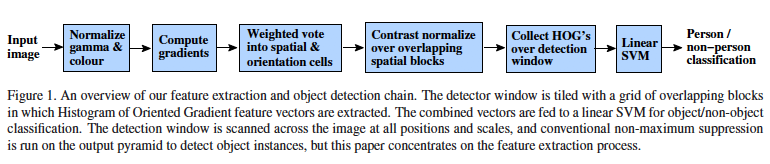

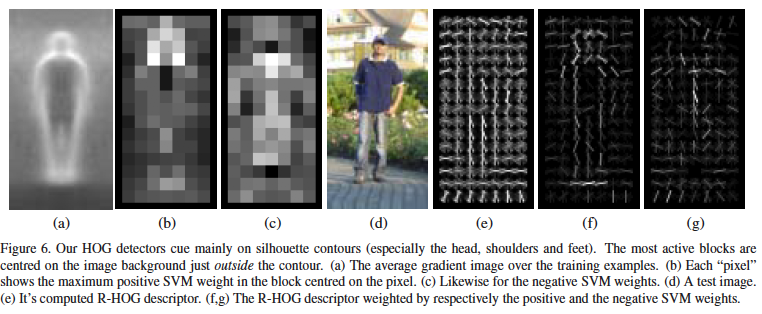

The above figures are from N. Dalal and B. Triggs, "Histograms of oriented gradients for human detection," 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05), San Diego, CA, USA, 2005, pp. 886-893 vol. 1, DOI: 10.1109/CVPR.2005.177.

# People detection using HOG

We can use the HOG features to detect objects, i.e., people in images. 

1. Train an SVM classifier to take in a fixed-sized window and classify it as containing human or not. 
2. Use the sliding window technique to detect people across the whole image. Place the window at a location in the image, classify the region, and then slide over by "stride" pixels, classify, slide, etc.
3. We can do these operations on multiple scales of an image pyramid to find the shape at various scales.



## Code: Remove overlapping bounding boxes

In [6]:
# Code to remove overlapping bounding boxes. This is used by the next cell
# https://www.computervisionblog.com/2011/08/blazing-fast-nmsm-from-exemplar-svm.html
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")


## Code: HOG-based person detection in video

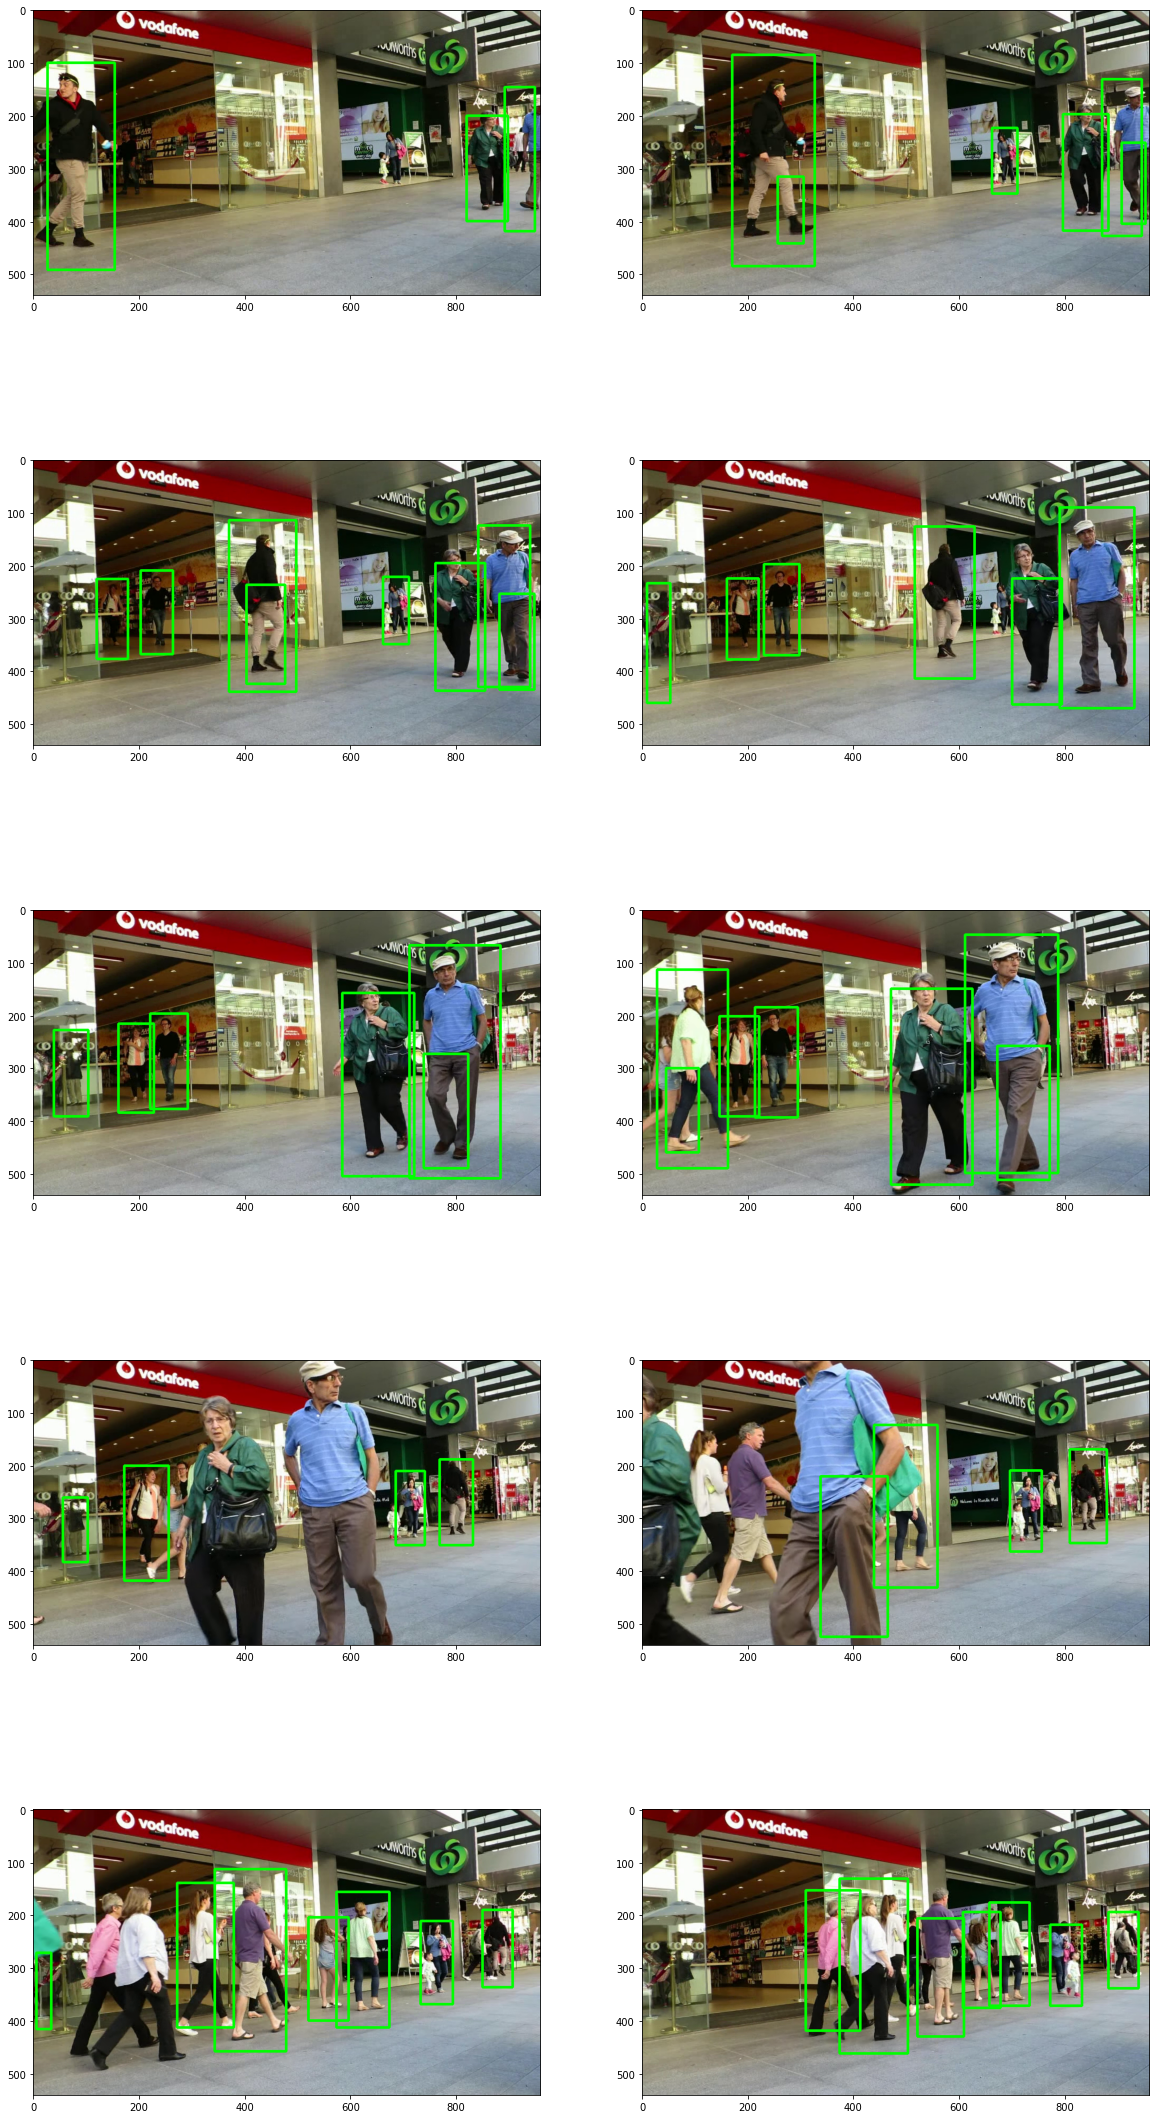

In [7]:
# (Python) An example applying the HOG descriptor for people detection can be 
# found at opencv_source_code/samples/python/peopledetect.py
# See: https://docs.opencv.org/master/de/da6/classcv_1_1cuda_1_1HOG.html for more details.
# 
#-------------------------------------------------------------------------------
def draw_detections(img, rects, thickness = 1):
# This function is taken from OpenCV
    for x, y, w, h in rects:
        # the HOG detector returns slightly larger rectangles than the real objects.
        # so we slightly shrink the rectangles to get a nicer output.
        pad_w, pad_h = int(0.15*w), int(0.05*h)
        cv2.rectangle(img, (x+pad_w, y+pad_h), (x+w-pad_w, y+h-pad_h), (0, 255, 0), thickness)
#-------------------------------------------------------------------------------
hog = cv2.HOGDescriptor()
# See https://docs.opencv.org/master/d5/d33/structcv_1_1HOGDescriptor.html
# for more details about this class. 

hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector()) 

cap = cv2.VideoCapture('https://motchallenge.net/sequenceVideos/MOT16-09-raw.webm')

plt.figure(figsize=(20,40))

for i in range (10) :
    for j in range (25) : # skip 25 frames
        ret, current_frame = cap.read()
    current_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
        
    found, _w = hog.detectMultiScale(current_frame, winStride=(8,8), padding=(32,32), scale=1.1)
    # Detects objects of different sizes in the input image. The detected objects are returned as a 
    # list of rectangles. Returns a vector of rectangles where each rectangle contains the detected object.
    # along with confidences (_w) -- distance from SVM boundary
    # https://docs.opencv.org/master/d5/d33/structcv_1_1HOGDescriptor.html#a660e5cd036fd5ddf0f5767b352acd948
    # 
    # virtual void cv::HOGDescriptor::detectMultiScale	(InputArray 	img,
    # std::vector< Rect > & 	foundLocations,
    # double 	hitThreshold = 0,
    # Size 	winStride = Size(),
    # Size 	padding = Size(),
    # double 	scale = 1.05,
    # double 	finalThreshold = 2.0,
    # bool 	useMeanshiftGrouping = false 
    # )		cons
    # The parameters of this function is explained well at 
    # https://www.pyimagesearch.com/2015/11/16/hog-detectmultiscale-parameters-explained/
    # "Tune your scale  and winStride  parameters. These two arguments have a tremendous impact 
    # on your object detector speed. Both scale  and winStride  should be as large as possible, 
    # again, without sacrificing detector accuracy. Keep in mind that for each layer of the pyramid a 
    # sliding window with winStride  steps is moved across the entire layer. While it’s important to evaluate 
    # multiple layers of the image pyramid, allowing us to find objects in our image at different scales, 
    # it also adds a significant computational burden since each layer also implies a series of sliding 
    # windows, HOG feature extractions, and decisions by our SVM must be performed."
    #
    # Typical values for scale  are normally in the range [1.01, 1.5]. 
    
    found_filtered = non_max_suppression_fast(found, overlapThresh=0.65)

    #draw_detections(current_frame, found, thickness = 3)
    draw_detections(current_frame, found_filtered, thickness = 3)
    #!print('%d (%d) found' % (len(found_filtered), len(found)))
    plt.subplot(5,2,i+1)
    plt.imshow(current_frame)

cap.release()
cv2.destroyAllWindows()
